# Example 2: An Ideal, Ternary Mixture

This example shows the distillation column for a mixture of Benzene (heavy key), Toluene (intermediate) and Xylene (light key).

The Rectifying and Stripping operating lines are curves in the ternary plot.  The symbols represent the equilibrium composition of liquid that exits a stage.  

A column designed is deemed feasible when the Rectifying and Stripping operating lines overlap.

In [1]:
## IMPORT NECESSARY LIBRARIES ##
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.thermo_models.RaoultsLawModel import *
from src.utils.AntoineEquation import * 

from IPython.display import clear_output
from src.distillation.DistillationTernary import *

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Button, VBox, HBox, Output

import pickle
from src.utils.dictionary_approx import *
from src.distillation.residue_curves import *

with open("src/utils/pickles/ex2_fixedpoints_dict.pkl", "rb") as f:
    rtofixedpoints_dict = pickle.load(f)
    
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})

/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


**Here, the vapor-liquid equilibrium model for the ternary system is being defined.**

In [2]:
# Antoine Parameters for benzene
Ben_A = 4.72583; Ben_B = 1660.652; Ben_C = -1.461

# Antoine Parameters for toluene
Tol_A = 4.07827; Tol_B = 1343.943; Tol_C = -53.773

# Antoine Parameters for Xylene
Xyl_A = 4.14553; Xyl_B = 1474.403; Xyl_C = -55.377

P_sys = 1.01325
# Create Antoine equations for benzene and toluene
benzene_antoine = AntoineEquationBase10(Ben_A, Ben_B, Ben_C)
toluene_antoine = AntoineEquationBase10(Tol_A, Tol_B, Tol_C)
xylene_antoine  = AntoineEquationBase10(Xyl_A, Xyl_B, Xyl_C)

# Create a Raoult's law object
TolBenXylSys = RaoultsLawModel(3,P_sys,["Benzene", "Toluene", "Xylene"],[benzene_antoine, toluene_antoine, xylene_antoine])

*Create sliders*

In [3]:
#Changing Reflux Ratio Example

reflux_ex_R_slider  = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.001,  description='Reflux Ratio:', readout_format='.3f')
reflux_ex_go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
reflux_ex_oplines   = Output()

*Define plot functions*

In [4]:
def plot_mb(dist_model,ax = None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize= (6,5))
    dist_model.plot_mb(ax)
    if ax is None:
        plt.tight_layout()
        plt.show()

def reflux_ex_plot_rect_strip(dist_model, rcm, R):
        
    dist_model.set_xF(np.array([0.3, 0.3, 0.4]))
    dist_model.set_xB(np.array([1e-5, 0.4261,0.5749]))
    dist_model.set_xD(np.array([0.990, 0.0100, 1e-10]))
    dist_model.set_r(R)
    
    fixed_points = approximate_value(rtofixedpoints_dict,R)
    fig, ax      = plt.subplots(2,2,figsize= (10,10))
    
    dist_model.plot_rect_strip_comp(ax[0,0])
    
    for index,point in enumerate(fixed_points['values']):
        ax[0,1].scatter(point[0], point[1], marker='2', s=25, color = '#3182bd', linewidths= 10)
        
        if fixed_points['source_indices'][index] == 0:
            label = "Unstable"
        elif fixed_points['source_indices'][index] == 1:
            label = "saddle"
        elif fixed_points['source_indices'][index] == 2:
            label = "stable"
        else:
            label = "unexpected node: error"
        ax[0,1].text(point[0], point[1], f' {label}', verticalalignment='bottom', horizontalalignment='right', fontsize = 12)
    
    ax[0,1].hlines
    
    ax[0,1].set_xlim([-0.05,1.05])                                                                                                   
    ax[0,1].set_ylim([-0.05,1.05]) 
    
    ax[0,1].plot([1,0], [0,1], color  = 'k', linestyle  = 'dashed') 
    ax[0,1].hlines(0, 0, 1,    colors = 'k', linestyles = 'dashed')  # dashed line                                               
    ax[0,1].vlines(0, 0, 1,    colors = 'k', linestyles = 'dashed')  # dashed line                                               
    
    ax[0,1].set_xlabel(dist_model.thermo_model.comp_names[0], labelpad = 10)                                                        
    ax[0,1].set_ylabel(dist_model.thermo_model.comp_names[1], labelpad = 10) 
        
    #Plot Rectifying and stripping vector fields
    rcm.plot_vector_field_rect (ax[1,0], 20)
    rcm.plot_vector_field_strip(ax[1,1], 20)
    
    dist_model.plot_rect_comp(ax[1,0])
    dist_model.plot_strip_comp(ax[1,1])
    
    for i in ax:
        for j in i:
            j.set_aspect('equal')

    plt.subplots_adjust(hspace=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Mass balance over a distillation column

We first create a distillation column object. **Modify the distillate and bottoms compositions**

The feed, distillate and bottoms compositions are always collinear due to mass balance.

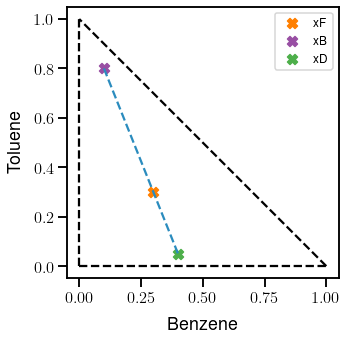

In [5]:
# Create a distillation model object
xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.4, 0.05, 0.55])
xB = np.array([0.1,0.8,0.1])

distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = 1)

# Create a residue curve map object
rcm = PhasePortraits(TolBenXylSys,distillation_model)

plot_mb(distillation_model)

# Effects of Changing Reflux Ratio on Operating Compositions

Unlike binary distillation, the VLE surface and the rectifying and stripping operating lines in a ternary system reside in a 4-dimensional space. These hyperplanes are parameterized by the liquid and vapor mole fractions $x_1$, $x_2$, $y_1$, and $y_2$. The third component's mole fraction in both phases is determinable from the first two, allowing for a reduction in dimensionality. Traditional 2D and 3D visualization tools are ill-suited for depicting these surfaces. Instead, compositions of liquid streams that exit a stage along the column offer a more effective visualization. In the binary case these where the symbols projected on the x-axis (See Example 1).

## Interpretation of Graphical Elements

### What Do the Blue and Red Points Signify?

These points represent the stage-wise liquid phase compositions as one moves along the column. In binary systems, these correspond to the zig-zag path across the McCabe-Thiele diagram.

### Why Are There Two Curves?

Just as in binary distillation, these curves stem from different starting points: one originates from the bottoms (stripping OL) and the other from the distillate (rectifying OL). 

### Criteria for a Feasible Column

Drawing a parallel to binary systems, a feasible column is one where the rectifying and stripping compositions intersect. This ensures a smooth transition in composition from the distillate to the bottoms along the column. In graphical terms, feasibility is indicated by an overlap between the rectifying and stripping curves.

#### Interactive Exploration

Move the slider to observe how the column's behavior changes. Your goal is to configure a column in which the rectifying and stripping curves overlap, signifying feasible operation. Take note of the location of fixed points—these are analogous to the intersection points between operating and equilibrium curves in binary distillation. Just like in the binary case, these fixed points define regions of infeasible compositions.

In [6]:
def relux_ex_button(b):
    with reflux_ex_oplines:
        clear_output()
        plt.close('all')  # Close all open matplotlib plots
        reflux_ex_plot_rect_strip( distillation_model, rcm, R = reflux_ex_R_slider.value)
        
go_button = Button(description='Generate Plot')
go_button.on_click(relux_ex_button)

reflux_ex_display = VBox([HBox([reflux_ex_R_slider, go_button]), reflux_ex_oplines])

display(reflux_ex_display)

## Selecting Stream Compositions: Theoretical Insights and Practical Implications

Not all target distillate / bottoms compositions are possible or practical for operation. We're going to show you some examples—actual plots that lay out what works and what doesn't when you choose different product compositions. These examples will give you a hands-on look at how your choices directly affect the feasibility of your distillation column. Think of it as a visual guide to avoiding common pitfalls in design and operation.

### You can't enrich heaviest component in the Distillate

This might seem obvious, but it is less intuitive here than the binary case. Despite whatever reflux ratio you choose for this selection of components, the two composition curves will never overlap

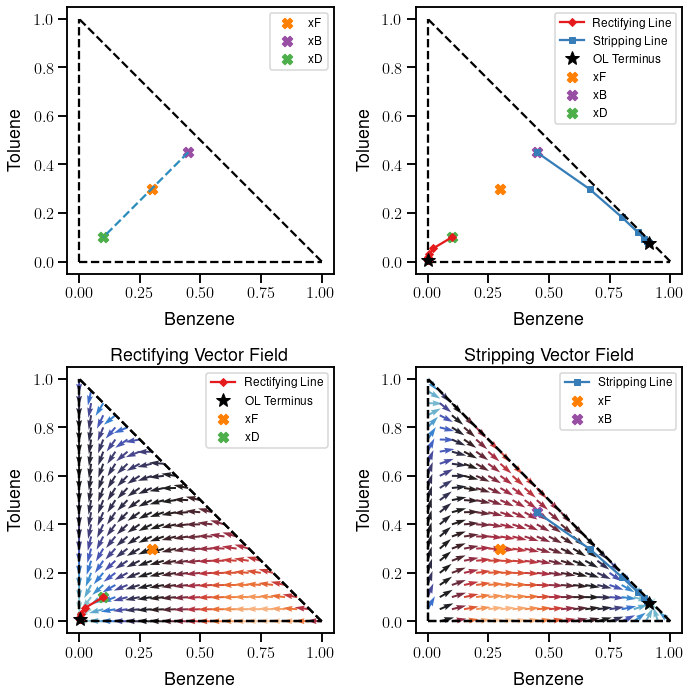

In [7]:
fig, ax = plt.subplots(2,2,figsize= (10,10)) ##CHECK MASS BALANCE
#Impossible case (dist)

distillation_model.set_xF(np.array([0.3, 0.3, 0.4]))
distillation_model.set_xB(np.array([0.45, 0.45, 0.1]))
distillation_model.set_xD(np.array([0.1, 0.1, 0.8]))

# Change the value of reflux ratio
distillation_model.set_r(10)

plot_mb(distillation_model, ax[0,0])
distillation_model.plot_rect_strip_comp(ax[0,1]) 
rcm.plot_vector_field_rect(ax[1,0]); rcm.plot_vector_field_strip(ax[1,1])

# Uncomment these two lines to show the vector field
distillation_model.plot_rect_comp(ax[1,0])
distillation_model.plot_strip_comp(ax[1,1])

for i in ax.flatten():
    i.set_aspect('equal')
    
plt.tight_layout()
plt.show()

### You can't Enrich Intermediate Component in the Bottoms or Tops

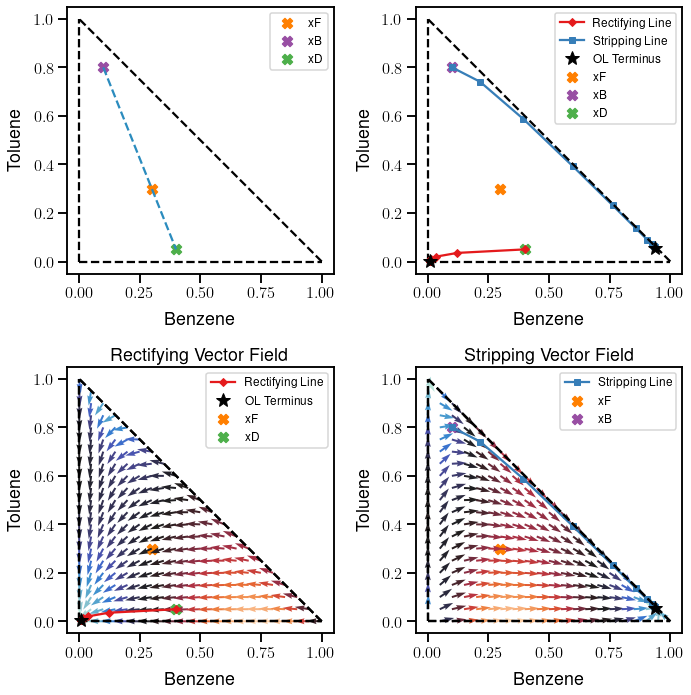

In [8]:
#Show different splits
fig, ax = plt.subplots(2,2,figsize = (10,10))

#Possible case

distillation_model.set_xF(np.array([0.3, 0.3, 0.4]))
distillation_model.set_xD(np.array([0.4, 0.05, 0.55]))
distillation_model.set_xB(np.array([0.1, 0.8, 0.1]))

# Change the reflux ration to any number of your choice
distillation_model.set_r(10)
plot_mb(distillation_model, ax[0,0])
distillation_model.plot_rect_comp(ax[1,0])
distillation_model.plot_strip_comp(ax[1,1])

distillation_model.plot_rect_strip_comp(ax[0,1])
rcm.plot_vector_field_rect(ax[1,0]); rcm.plot_vector_field_strip(ax[1,1])
for i in ax.flatten():
    i.set_aspect('equal')
    
plt.tight_layout()
plt.show()

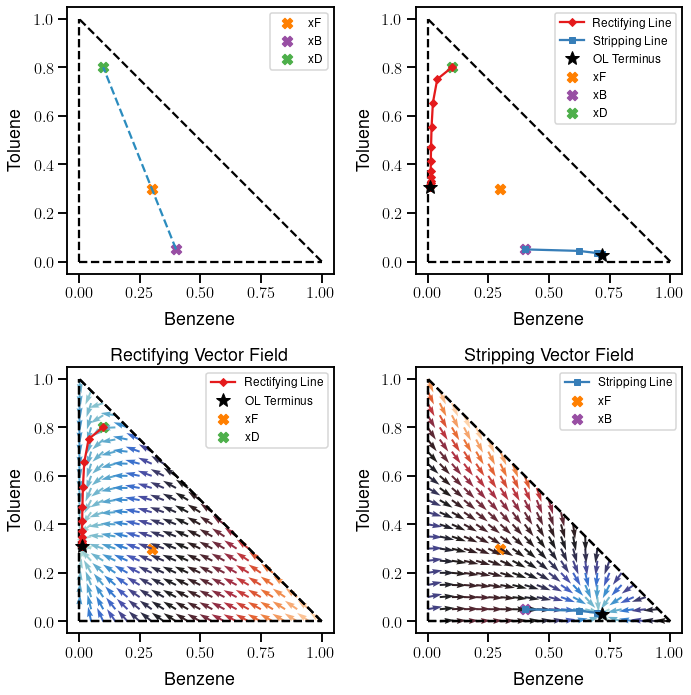

In [9]:
fig, ax = plt.subplots(2,2,figsize= (10,10))

distillation_model.set_xF(np.array([0.3, 0.3, 0.4]))
distillation_model.set_xD(np.array([0.1, 0.8, 0.1]))
distillation_model.set_xB(np.array([0.4, 0.05, 0.55]))

# Change the reflux ration to any number of your choice
distillation_model.set_r(2)
plot_mb(distillation_model, ax[0,0])
distillation_model.plot_rect_strip_comp(ax[0,1])
distillation_model.plot_rect_comp(ax[1,0])
distillation_model.plot_strip_comp(ax[1,1])

rcm.plot_vector_field_rect(ax[1,0]); rcm.plot_vector_field_strip(ax[1,1])
for i in ax.flatten():
    i.set_aspect('equal')
    
plt.tight_layout()
plt.show()

### Possible Case: Enrichment of Light-key Component in Distillate and Lowkey + Intermediate Component in Bottoms 

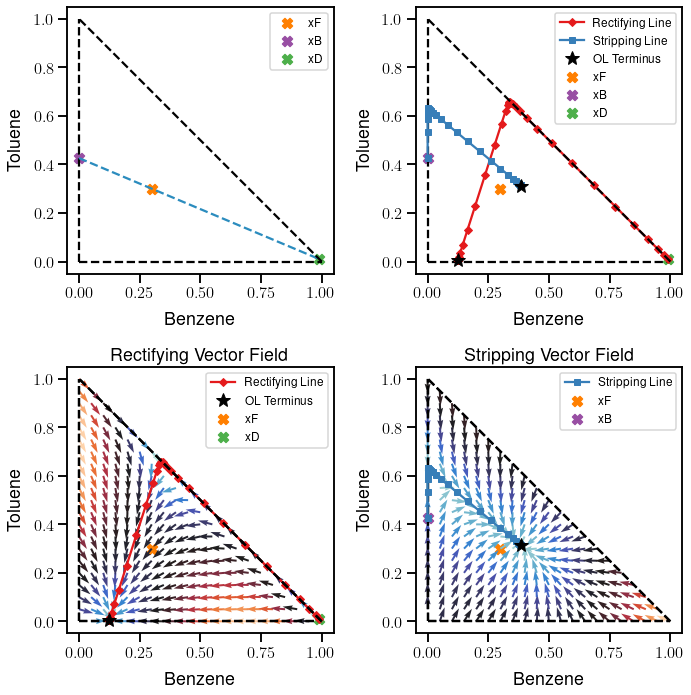

In [10]:
#Show different splits
fig, ax = plt.subplots(2,2,figsize= (10,10))

distillation_model.set_xF(np.array([0.3, 0.3, 0.4]))
distillation_model.set_xD(np.array([0.990, 0.0100, 1e-10]))
distillation_model.set_xB(np.array([1e-5, 0.4261,0.5749-1e-5]))

distillation_model.set_r(2)

plot_mb(distillation_model, ax[0,0])
distillation_model.plot_rect_strip_comp(ax[0,1])
distillation_model.plot_rect_comp(ax[1,0])
distillation_model.plot_strip_comp(ax[1,1])

rcm.plot_vector_field_rect(ax[1,0]); rcm.plot_vector_field_strip(ax[1,1])

for i in ax.flatten():
    i.set_aspect('equal')
    
for i in ax.flatten():
    i.set_aspect('equal')
    
plt.tight_layout()
plt.show()